In [1]:
import os
import random
from random import shuffle
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
from fedlab.utils.dataset.partition import SVHNPartitioner
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

In [2]:
# Define transformations
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

In [3]:
# SVHN Dataset
dataset_path = os.path.join("path_to_data")
trainset = torchvision.datasets.SVHN(
    root=dataset_path, split="train", download=True, transform=transform
)
testset = torchvision.datasets.SVHN(
    root=dataset_path, split="test", download=True, transform=transform
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182M/182M [00:19<00:00, 9.21MB/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64.3M/64.3M [00:10<00:00, 6.18MB/s]


In [4]:
# Partition Data
num_clients = 100
seed = 2021
alpha_values = [0.1, 0.3, 1.0, 5.0, 10.0]

partitions = {}
for alpha in alpha_values:
    partitions[f"Dirichlet_alpha_{alpha}"] = SVHNPartitioner(
        targets=trainset.labels,
        num_clients=num_clients,
        partition="noniid-labeldir",
        dir_alpha=alpha,
        seed=seed,
    )

In [5]:
def full_knowledge_trim_attack(client_dict, target_classes, trim_fraction, scarcity_clients):
    adjusted_client_dict = {}
    for client, indices in client_dict.items():
        class_indices = {}
        for idx in indices:
            label = trainset.labels[idx]
            if label not in class_indices:
                class_indices[label] = []
            class_indices[label].append(idx)

        adjusted_indices = []
        for label, label_indices in class_indices.items():
            shuffle(label_indices)
            if client in scarcity_clients and label in target_classes:
                continue
            elif label in target_classes:
                trim_count = int(len(label_indices) * trim_fraction)
                adjusted_indices.extend(label_indices[:trim_count])
            else:
                adjusted_indices.extend(label_indices)

        adjusted_client_dict[client] = adjusted_indices

    return adjusted_client_dict

In [6]:
target_classes = [0, 1, 2, 3, 4]
initial_scarcity_fraction = 0.3
scarcity_increment = 0.05

attack_results = {}
for name, part in partitions.items():
    alpha = float(name.split("_")[-1])
    trim_fraction = 0.7 + (alpha * 0.3)
    scarcity_fraction = initial_scarcity_fraction + (scarcity_increment * alpha)

    num_scarcity_clients = int(len(part.client_dict) * scarcity_fraction)
    scarcity_clients = random.sample(
        list(part.client_dict.keys()), num_scarcity_clients
    )

    adjusted_client_dict = full_knowledge_trim_attack(
        part.client_dict, target_classes, trim_fraction, scarcity_clients
    )
    attack_results[name] = {"adjusted_client_dict": adjusted_client_dict}


In [7]:
# Prepare DataLoaders
def prepare_dataloader(client_dict, dataset, batch_size=32):
    indices = [idx for client_indices in client_dict.values() for idx in client_indices]
    subset = Subset(dataset, indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=True, drop_last=True)
    return loader


original_loaders = {
    name: prepare_dataloader(partitioner.client_dict, trainset)
    for name, partitioner in partitions.items()
}
attack_loaders = {
    name: prepare_dataloader(result["adjusted_client_dict"], trainset)
    for name, result in attack_results.items()
}

In [8]:
# Define Model (Simple CNN)
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(64 * 16 * 16, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
# Train and Evaluate
def train_model(model, train_loader, test_loader, epochs=15, device="cpu"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=5
    )

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step(epoch_loss / len(train_loader))

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total

Evaluating Dirichlet_alpha_0.1 Partition...
Evaluating Dirichlet_alpha_0.1 Partition Post-Attack...
Evaluating Dirichlet_alpha_0.3 Partition...
Evaluating Dirichlet_alpha_0.3 Partition Post-Attack...
Evaluating Dirichlet_alpha_1.0 Partition...
Evaluating Dirichlet_alpha_1.0 Partition Post-Attack...
Evaluating Dirichlet_alpha_5.0 Partition...
Evaluating Dirichlet_alpha_5.0 Partition Post-Attack...
Evaluating Dirichlet_alpha_10.0 Partition...
Evaluating Dirichlet_alpha_10.0 Partition Post-Attack...


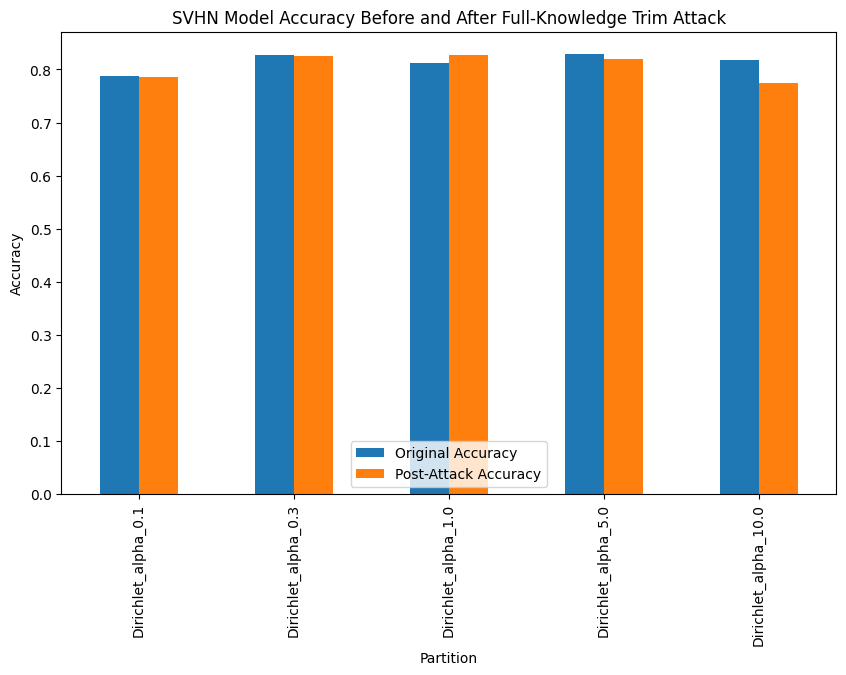

In [10]:
# Evaluate Results
results = []
device = "cuda" if torch.cuda.is_available() else "cpu"
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

for name, train_loader in original_loaders.items():
    print(f"Evaluating {name} Partition...")
    model = SimpleCNN()
    original_accuracy = train_model(
        model, train_loader, test_loader, epochs=15, device=device
    )

    print(f"Evaluating {name} Partition Post-Attack...")
    model = SimpleCNN()
    post_attack_accuracy = train_model(
        model, attack_loaders[name], test_loader, epochs=15, device=device
    )

    results.append(
        {
            "Partition": name,
            "Original Accuracy": original_accuracy,
            "Post-Attack Accuracy": post_attack_accuracy,
        }
    )

# Plot Results
results_df = pd.DataFrame(results)
results_df.set_index("Partition").plot(kind="bar", figsize=(10, 6))
plt.title("SVHN Model Accuracy Before and After Full-Knowledge Trim Attack")
plt.ylabel("Accuracy")
plt.xlabel("Partition")
plt.savefig("FKTA_results_SVHN.png", dpi=300)
plt.show()